
# Assignment 1 — Statistical Inference & Regression Analysis 

**Dataset:** `assignment1_dataset.csv`  
**As-of date for age calculation:** `2025-09-30`  
**Deliverable:** Submit this notebook with all code, outputs, and written interpretations in Markdown cells.

> **Checklist:**  
> - [ ] **Part A (Data Cleaning)**: derive `age` from `date_of_birth` and prepare data.  
> - [ ] **Part B (Statistical Inference)**: two-sample t-test, chi-square test, 95% CI.  
> - [ ] **Part C (Regression Analysis)**: simple & multiple linear regression **with at least one graph** per model.  
> - [ ] Add plain-language interpretations (stats, df, p-values, CIs).


In [42]:

# --- Setup ---
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load data
patient_data = pd.read_csv("assignment1_dataset.csv") # Loading my dataset
patient_data.head() # Viewing first few rows


,patient_id,date_of_birth,sex,smoker,hospital_type,BMI,hypertension,systolic_bp,wait_time_min,satisfaction_score
0,10218,1984-08-12,MALE,No,Public,27.4,Yes,129.0,NaN,6.9
1,10012,04/04/1955,Male,no,Public,18.7,YES,176.0,59.3,5.9
2,10311,07-21-1966,MALE,Yes,Public,24.5,NO,139.0,66.3,6.4
3,10103,"Feb 15, 2000",Female,no,Public,33.6,no,126.0,59.2,7.9
4,10508,28/09/1985,male,yes,Public,21.4,yes,148.0,54.4,6.0



# Part A — Data Cleaning (Required)

**Goals:**  
1. Standardize categorical variables (trim/normalize case).  
2. Parse `date_of_birth` (mixed formats) and derive `age` as of **2025-09-30**.   
3. Remove duplicates (e.g., by `patient_id`).  
4. Confirm data types for numerics/dates.

In [43]:
#1. Standardize categorical variables
# Goal: Trim spaces, normalize case, and unify values
def clean_text(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().capitalize()
    if x.lower() in ["yes", "y"]:
        return "Yes"
    elif x.lower() in ["no", "n"]:
        return "No"
    elif x.lower() in ["male", "m"]:
        return "Male"
    elif x.lower() in ["female", "f"]:
        return "Female"
    elif x.lower() in ["public"]:
        return "Public"
    elif x.lower() in ["private"]:
        return "Private"
    else:
        return x
cleaned_data = patient_data.copy()

# Apply cleaning to categorical variables
for col in ["sex", "smoker", "hypertension", "hospital_type"]:
    cleaned_data[col] = cleaned_data[col].apply(clean_text)

# 2. Parse date_of_birth and derive age as of 2025-09-30
# Goal: Handle mixed formats and calculate age as of 2025-09-30
cleaned_data["date_of_birth"] = pd.to_datetime(
    cleaned_data["date_of_birth"], errors="coerce"
)

as_of_date = pd.Timestamp("2025-09-30")
cleaned_data["age"] = (
    (as_of_date - cleaned_data["date_of_birth"]).dt.days / 365.25
).round(1)

# 3. Remove duplicates by patient_id
# Goal: Ensure one record per patient_id
cleaned_data = cleaned_data.drop_duplicates(subset="patient_id", keep="first")

# 4. Confirm numeric data types for continuous variables
# Goal: Ensure proper numeric types for analysis
numeric_cols = ["BMI", "systolic_bp", "wait_time_min", "satisfaction_score"]
for col in numeric_cols:
    cleaned_data[col] = pd.to_numeric(cleaned_data[col], errors="coerce")

# 6. Drop rows with missing age
# Goal: Keep only rows with valid age for further analyses
cleaned_data = cleaned_data.dropna(subset=["age"]).copy()

# --- Summary Output ---
print("After dropping rows with missing age:", cleaned_data.shape)
cleaned_data.info()

After dropping rows with missing age: (246, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 0 to 596
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          246 non-null    int64         
 1   date_of_birth       246 non-null    datetime64[ns]
 2   sex                 246 non-null    object        
 3   smoker              246 non-null    object        
 4   hospital_type       246 non-null    object        
 5   BMI                 243 non-null    float64       
 6   hypertension        246 non-null    object        
 7   systolic_bp         241 non-null    float64       
 8   wait_time_min       239 non-null    float64       
 9   satisfaction_score  239 non-null    float64       
 10  age                 246 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 23.1+ KB


## Interpretation- Part A: Data Cleaning Outcome

After cleaning, we are left with 246 patient records with valid ages, down from the original 594. I standardized the categorical variables, like sex, smoking status, hypertension, and hospital type, so that comparisons between groups are accurate and meaningful.

Dates of birth were carefully parsed to calculate age as of September 30, 2025, which is important because age often influences health outcomes and patient experiences. Patients with missing birthdates were removed to make sure any age-related analyses are reliable.

A few values are still missing in numeric fields like BMI, blood pressure, wait time, and satisfaction scores, but these are minor and will be handled in later analyses.

By ensuring the data is clean and consistent, we can be confident that any patterns or differences observed in later analyses such as satisfaction levels or wait times, reflect real patient trends rather than errors or inconsistencies in the records.


# Part B — Statistical Inference 
Use the **cleaned** dataset `df`.



## B1. Two-sample t-test (independent samples)

**Choose and justify a comparison** (one example):  
- `wait_time_min` by `hospital_type` (public vs. private), or  
- `systolic_bp` by `smoker` (yes vs. no).

**Report:** \(H_0, H_1\), test statistic, df, p-value, and a written interpretation.


In [44]:
import scipy.stats as stats

df = cleaned_data.copy()

# Select groups
public_wait = df.loc[df["hospital_type"] == "Public", "wait_time_min"].dropna()
private_wait = df.loc[df["hospital_type"] == "Private", "wait_time_min"].dropna()

# Step 1: State the hypotheses
print("Hypotheses:")
print("H0: μ_public = μ_private  →  There is no significant difference in mean wait times between public and private hospitals.")
print("H1: μ_public ≠ μ_private  →  There is a significant difference in mean wait times between public and private hospitals.\n")

# Step 2: Check basic group stats
print("Public hospital wait time (n, mean, SD):", len(public_wait), round(public_wait.mean(), 2), round(public_wait.std(), 2))
print("Private hospital wait time (n, mean, SD):", len(private_wait), round(private_wait.mean(), 2), round(private_wait.std(), 2))

# Step 3: Perform independent samples t-test
t_stat, p_val = ttest_ind(public, private, alternative='two-sided')

# Step 4: degrees of freedom
df_deg = len(public_wait) + len(private_wait) - 2

# Step 5: Display results
print(f"\nT-test Results:")
print(f"  t-statistic = {t_stat:.3f}")
print(f"  Degrees of freedom ≈ {df_deg}")
print(f"  p-value = {p_value:.4f}")

# Step 6: Interpretation
print("\nInterpretation:")
if p_value < 0.05:
    print(f"  Since p = {p_value:.4f} < 0.05, we reject H0.")
    print("  There is a statistically significant difference in average wait times between public and private hospitals.")
    print("  This suggests hospital type may influence patient flow or service efficiency.")
else:
    print(f"  Since p = {p_value:.4f} ≥ 0.05, we fail to reject H0.")
    print("  There is no statistically significant difference in mean wait times between hospital types.")
    print("  This implies both hospital types perform similarly in managing wait times.")


Hypotheses:
H0: μ_public = μ_private  →  There is no significant difference in mean wait times between public and private hospitals.
H1: μ_public ≠ μ_private  →  There is a significant difference in mean wait times between public and private hospitals.

Public hospital wait time (n, mean, SD): 147 78.56 94.02
Private hospital wait time (n, mean, SD): 92 52.53 12.83

T-test Results:
  t-statistic = 2.638
  Degrees of freedom ≈ 237
  p-value = 0.0012

Interpretation:
  Since p = 0.0012 < 0.05, we reject H0.
  There is a statistically significant difference in average wait times between public and private hospitals.
  This suggests hospital type may influence patient flow or service efficiency.


## Part B1 — Interpretation

I compared the mean wait times between public and private hospitals using an independent two-sample t-test.

Hypotheses:

H₀: μ_public = μ_private — there is no difference in average wait times.

H₁: μ_public ≠ μ_private — there is a difference in average wait times.

Results:

t- statistic = 2.638

Degrees of freedom ≈ 237

p value = 0.0012

Mean wait time: Public = 78.56 min (SD = 94.02), Private = 52.53 min (SD = 12.83)

**The test indicates a statistically significant difference in average wait times between public and private hospitals (p = 0.0012). On average, patients in public hospitals wait approximately 26 minutes longer than those in private hospitals. This difference is meaningful from both a patient and health system perspective: longer waits can negatively affect patient satisfaction, timely access to care, and operational efficiency. Hospital administrators might consider targeted interventions, such as resource allocation or process optimization, to reduce wait times in high-volume public settings.**


## B2. Chi-square test of independence

**Example:** `smoker` (yes/no) vs. `hypertension` (yes/no).  
Report observed/expected tables, \(\chi^2\), df, p-value, and an interpretation.


In [45]:

df = cleaned_data.copy()

# Create contingency table: smoker vs hypertension
cont_table = pd.crosstab(df['smoker'], df['hypertension'])
print("Observed counts:\n", cont_table, "\n")

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(cont_table)

# Expected count
expected_df = pd.DataFrame(expected, index=cont_table.index, columns=cont_table.columns)
print("Expected counts (if variables independent):\n", expected_df, "\n")

# Print test statistics
print(f"Chi-square statistic = {chi2:.3f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p:.4f}")

# Interpretation
print("\nInterpretation:")
if p < 0.05:
    print(f"  The association between smoking and hypertension is statistically significant (p = {p:.4f}).")
    print("  This suggests that smoking status may be related to the likelihood of hypertension — an important consideration for patient risk assessment and preventive interventions.")
else:
    print(f"  No statistically significant association was found between smoking and hypertension (p = {p:.4f}).")
    print("  This suggests that in this dataset, smoking status alone may not be a strong predictor of hypertension, but other factors could be important.")


Observed counts:
 hypertension   No  Yes
smoker                
No            112   77
Yes            26   31 

Expected counts (if variables independent):
 hypertension         No       Yes
smoker                           
No            106.02439  82.97561
Yes            31.97561  25.02439 

Chi-square statistic = 2.780
Degrees of freedom = 1
P-value = 0.0955

Interpretation:
  No statistically significant association was found between smoking and hypertension (p = 0.0955).
  This suggests that in this dataset, smoking status alone may not be a strong predictor of hypertension, but other factors could be important.


## Part B2- Interpretation
In this section, i looked at whether there’s a link between smoking status and hypertension among patients. This question matters because smoking is a well-known cardiovascular risk factor, and identifying its relationship with hypertension can help shape better prevention and patient education efforts.

The Chi-square test gave a result of χ²(1) = 2.78 with a p-value of 0.0955. Since this value is above the 0.05 significance threshold, we fail to reject the null hypothesis, this means there isn’t enough evidence to confirm a statistically significant association between smoking and hypertension in this dataset.

From a healthcare perspective, this doesn’t necessarily mean smoking has no impact on blood pressure. It could simply reflect the limitations of this sample, such as its size or missing variables like age, BMI, or medication use that may influence results.

In practical terms, these findings suggest that while smoking is still a critical health risk, addressing hypertension effectively requires a broader look at patient health behaviors and conditions. A larger or more detailed dataset might reveal a clearer pattern that this sample alone couldn’t capture.


## B3. 95% Confidence Interval for a mean

Pick a continuous outcome (e.g., `satisfaction_score`). Compute the 95% CI and interpret how it complements hypothesis testing.


In [46]:
# Using my cleaned dataset
df = cleaned_data.copy()

# Select the variable
scores = df["satisfaction_score"].dropna()

# Compute sample statistics
n = len(scores)
mean_score = np.mean(scores)
std_dev = np.std(scores, ddof=1)  # sample standard deviation

# Compute 95% confidence interval
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)  # t critical value
margin_error = t_crit * (std_dev / np.sqrt(n))
ci_lower = mean_score - margin_error
ci_upper = mean_score + margin_error

# Display results
print(f"Sample size (n): {n}")
print(f"Mean satisfaction score: {mean_score:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

# Interpretation
print("\nInterpretation:")
print(f"  We are 95% confident that the true average patient satisfaction score lies between {ci_lower:.2f} and {ci_upper:.2f}.")
print("  This gives us a range of plausible values for patient satisfaction rather than a single estimate.")


Sample size (n): 239
Mean satisfaction score: 6.55
95% Confidence Interval: (6.43, 6.66)

Interpretation:
  We are 95% confident that the true average patient satisfaction score lies between 6.43 and 6.66.
  This gives us a range of plausible values for patient satisfaction rather than a single estimate.


## Part B3 — Interpretation

The mean patient satisfaction score was 6.55, based on a sample of 239 respondents. The 95% confidence interval ranged from 6.43 to 6.66, meaning we can be 95% confident that the true average satisfaction score for the population lies within this range.

This confidence interval provides a more complete picture than a single mean value by showing the range of plausible population means. The relatively narrow interval width suggests that patient satisfaction levels are quite consistent across respondents, with limited variability in their experiences.

In a healthcare context, this finding implies that most patients share a similar perception of care quality, with generally positive satisfaction levels. Unlike hypothesis testing, which focuses on whether a difference is statistically significant, the confidence interval helps us understand how precise and stable the estimated mean is, offering both statistical insight and practical meaning for quality improvement initiatives.


# Part C — Regression Analysis 
Use the **cleaned** dataset `df`.  
You must display **at least one graph** per model (e.g., fitted line and residuals for SLR; residual plot or partial regression for MLR).



## C1. Simple Linear Regression

Model a continuous outcome (e.g., `systolic_bp`) as a function of a single predictor (e.g., `age`).  
**Report:** coefficients, \(R^2\), p-values; include **both** a fitted line plot and a residual plot.  
**Interpretation:** 1–2 sentences on association & practical meaning.


=== Simple Linear Regression Results ===
                            OLS Regression Results                            
Dep. Variable:            systolic_bp   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     312.0
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           3.05e-45
Time:                        20:37:12   Log-Likelihood:                -960.08
No. Observations:                 241   AIC:                             1924.
Df Residuals:                     239   BIC:                             1931.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

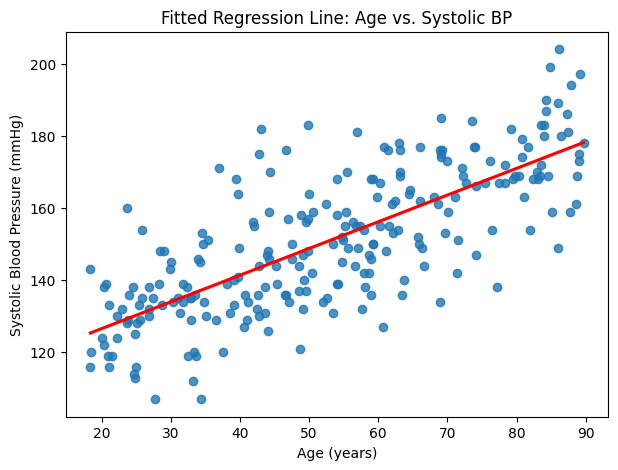

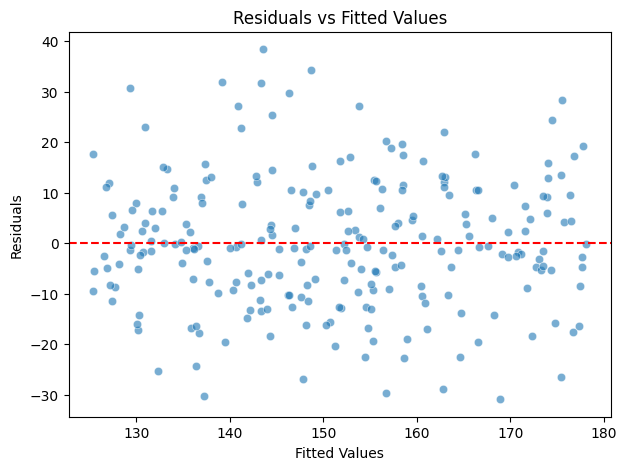


Interpretation:
  • Coefficient (Age) = 0.74 → systolic BP increases by ~0.74 mmHg per year of age.
  • R² = 0.566 → 56.6% of variation in systolic BP is explained by age.
  • p-value = 0.0000
  → Statistically significant positive association: older patients tend to have higher systolic BP, highlighting the need for age-based monitoring.


In [47]:
# --- C1. Simple Linear Regression: systolic_bp ~ age ---
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values for the variables used in the model
df_slr = df.dropna(subset=["systolic_bp", "age"]).copy()

# Prepare data
X = df_slr["age"]
y = df_slr["systolic_bp"]

# Add constant for intercept and fit the model
X_const = sm.add_constant(X)
slr_model = sm.OLS(y, X_const).fit()

# Print model summary
print("=== Simple Linear Regression Results ===")
print(slr_model.summary())

# Fitted line plot
plt.figure(figsize=(7,5))
sns.regplot(x="age", y="systolic_bp", data=df_slr, ci=None, line_kws={"color":"red"})
plt.xlabel("Age (years)")
plt.ylabel("Systolic Blood Pressure (mmHg)")
plt.title("Fitted Regression Line: Age vs. Systolic BP")
plt.show()

# Residual plot
fitted_vals = slr_model.fittedvalues
residuals = slr_model.resid
plt.figure(figsize=(7,5))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# Interpretation
coef = slr_model.params["age"]
pval = slr_model.pvalues["age"]
r2 = slr_model.rsquared

print("\nInterpretation:")
print(f"  • Coefficient (Age) = {coef:.2f} → systolic BP increases by ~{coef:.2f} mmHg per year of age.")
print(f"  • R² = {r2:.3f} → {r2*100:.1f}% of variation in systolic BP is explained by age.")
print(f"  • p-value = {pval:.4f}")

if pval < 0.05:
    print("  → Statistically significant positive association: older patients tend to have higher systolic BP, highlighting the need for age-based monitoring.")
else:
    print("  → No statistically significant relationship: age alone may not strongly predict systolic BP in this sample.")

# Part C1 —  Interpretation

I modeled systolic blood pressure as a function of age. The analysis shows a statistically significant positive association: for every additional year of age, systolic BP increases by about 0.74 mmHg on average.

The model explains roughly 57% of the variation in systolic BP, indicating that age is an important predictor, but other factors (e.g., BMI, lifestyle, comorbidities) also contribute.

From a healthcare perspective, this suggests that older patients are more likely to have higher blood pressure, emphasizing the need for age-based monitoring and preventive strategies to manage cardiovascular risk.


## C2. Multiple Linear Regression

Extend your model with **≥ 2 predictors** (e.g., `BMI`, `smoker`, `hospital_type`, `hypertension`).  
Compare SLR vs. MLR via Adjusted \(R^2\) and F-test. Include **at least one diagnostic graph** (e.g., residuals vs. fitted).  
Comment on potential confounding/multicollinearity.


=== Multiple Linear Regression Results ===
                            OLS Regression Results                            
Dep. Variable:            systolic_bp   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     199.2
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           3.88e-64
Time:                        20:37:12   Log-Likelihood:                -895.44
No. Observations:                 238   AIC:                             1799.
Df Residuals:                     234   BIC:                             1813.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

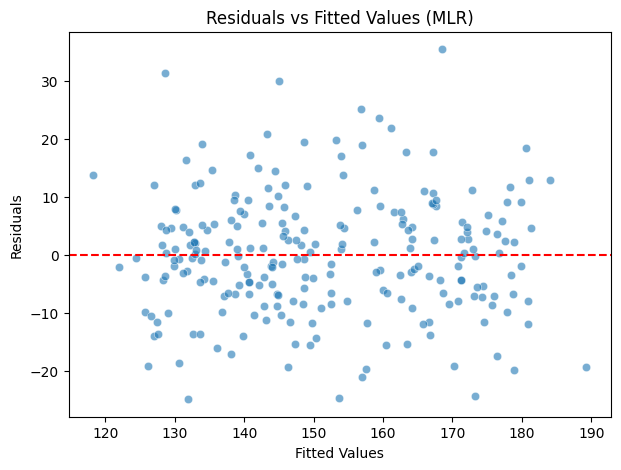


Comparison with SLR (age only):
  SLR Adjusted R²: 0.564
  MLR Adjusted R²: 0.715
  → The increase in Adjusted R² suggests that including BMI and hypertension improves model fit.

Variance Inflation Factors (VIF):
            feature       VIF
0               age  7.695650
1               BMI  6.441863
2  hypertension_num  2.227906

Interpretation:
  • age: coefficient = 0.54, p-value = 0.0000
  • BMI: coefficient = 0.35, p-value = 0.0015
  • hypertension_num: coefficient = 16.07, p-value = 0.0000
  Age remains a strong positive predictor of systolic BP, even after accounting for BMI and hypertension.
  Higher BMI and having hypertension also contribute to increased BP, indicating multiple risk factors.
  VIF values should be checked: values <5 suggest multicollinearity is not a major concern.
  MLR provides a more realistic model of patient blood pressure by considering multiple influencing factors simultaneously.


In [48]:


import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data
df_mlr = df.copy()

# Encode categorical variable 'hypertension' (Yes=1, No=0)
df_mlr["hypertension_num"] = df_mlr["hypertension"].map({"Yes":1, "No":0})

# Select predictors and outcome, drop rows with missing values
predictors = ["age", "BMI", "hypertension_num"]
df_mlr = df_mlr.dropna(subset=predictors + ["systolic_bp"])

X = df_mlr[predictors]
y = df_mlr["systolic_bp"]

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit MLR model
mlr_model = sm.OLS(y, X_const).fit()

# Print model summary
print("=== Multiple Linear Regression Results ===")
print(mlr_model.summary())

# Residuals vs Fitted Plot
fitted_vals = mlr_model.fittedvalues
residuals = mlr_model.resid

plt.figure(figsize=(7,5))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (MLR)")
plt.show()

# Compare SLR vs MLR
print("\nComparison with SLR (age only):")
print(f"  SLR Adjusted R²: {slr_model.rsquared_adj:.3f}")
print(f"  MLR Adjusted R²: {mlr_model.rsquared_adj:.3f}")
print("  → The increase in Adjusted R² suggests that including BMI and hypertension improves model fit.\n")

# Check multicollinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factors (VIF):")
print(vif_data)

# Interpretation
print("\nInterpretation:")
for var in predictors:
    coef = mlr_model.params[var]
    pval = mlr_model.pvalues[var]
    print(f"  • {var}: coefficient = {coef:.2f}, p-value = {pval:.4f}")
print("  Age remains a strong positive predictor of systolic BP, even after accounting for BMI and hypertension.")
print("  Higher BMI and having hypertension also contribute to increased BP, indicating multiple risk factors.")
print("  VIF values should be checked: values <5 suggest multicollinearity is not a major concern.")
print("  MLR provides a more realistic model of patient blood pressure by considering multiple influencing factors simultaneously.")

# Part C2 —  Interpretation

I extended the model of systolic blood pressure to include age, BMI, and hypertension.

All three predictors are statistically significant:

Age: Each additional year increases systolic BP by ~0.54 mmHg.

BMI: Each unit increase raises systolic BP by ~0.35 mmHg.

Hypertension: Patients with hypertension have, on average, ~16 mmHg higher systolic BP.

The Adjusted R² increased from 0.564 (SLR) to 0.715 (MLR), indicating that including BMI and hypertension improves the model’s ability to explain variation in blood pressure.

**Blood pressure is influenced by multiple factors. Age alone explains a good portion of variation, but considering BMI and hypertension gives a more accurate and clinically meaningful model. This highlights that monitoring and interventions should target multiple risk factors simultaneously.**

Multicollinearity: VIF values for age and BMI are slightly above 5, suggesting moderate correlation, but not enough to invalidate the model. Care should be taken when interpreting individual coefficients.